In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

from keras.models import Model
from keras.layers import Dense, Activation, Input, Reshape
from keras.layers import Conv1D, Flatten, Dropout
from keras.optimizers import SGD, Adam


from tqdm import tqdm_notebook as tqdm  # 进度条

D:\environment\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# 生成随机正弦曲线的数据
def sample_data(n_samples=10000, x_vals=np.arange(0, 5, .1), max_offset=1000, mul_range=[1, 2]):
    vectors = []
    for i in range(n_samples):
        offset = np.random.random() * max_offset
        mul = mul_range[0] + np.random.random() * (mul_range[1] - mul_range[0])
        vectors.append(np.sin(offset + x_vals * mul) / 2 + .5)
        
    return np.array(vectors)
    
# 创建生成模型
def get_generative(G_in, dense_dim=200, out_dim=50, lr=1e-3):
    x = Dense(dense_dim)(G_in)
    x = Activation('tanh')(x)
    G_out = Dense(out_dim, activation='tanh')(x)
    G = Model(G_in, G_out)
    opt = SGD(lr=lr)
    
    G.compile(loss='binary_crossentropy', optimizer=opt)
    
    return G, G_out
    
# 创建判别模型
def get_discriminative(D_in, lr=1e-3, drate = .25, n_channels=50, conv_sz=5, leak=.2):
    x = Reshape((-1, 1))(D_in)
    x = Conv1D(n_channels, conv_sz, activation='relu')(x)
    x = Dropout(drate)(x)
    x = Flatten()(x)
    x = Dense(n_channels)(x)
    D_out = Dense(2, activation='sigmoid')(x)
    D = Model(D_in, D_out)
    dopt = Adam(lr=lr)
    D.compile(loss='binary_crossentropy', optimizer=dopt)
    
    return D, D_out

    
    
def set_trainability(model, trainable=False):
    model.trainable = trainable
    for layer in model.layers:
        layer.trainable = trainable
        
def make_gan(GAN_in, G, D):
    set_trainability(D, False)
    x = G(GAN_in)
    GAN_out = D(x)
    GAN = Model(GAN_in, GAN_out)
    GAN.compile(loss='binary_crossentropy', optimizer=G.optimizer)
    return GAN, GAN_out

# 通过生成数据 预训练判别模型
def sample_data_and_gen(G, noise_dim=10, n_samples=10000):
    XT = sample_data(n_samples=n_samples)
    XN_noise = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    XN = G.predict(XN_noise)
    X = np.concatenate((XT, XN))
    y = np.zeros((2*n_samples, 2))
    y[:n_samples, 1] = 1
    y[n_samples:, 0] = 1

    return X, y
     
def pretrain(G, D, noise_dim=10, n_samples=10000, batch_size=32):
    X, y = sample_data_and_gen(G, noise_dim=noise_dim, n_samples=n_samples)
    set_trainability(D, True)
    D.fit(X, y, epochs=1, batch_size=batch_size)
    
    
# 开始交叉训练步骤
def sample_noise(G, noise_dim=10, n_samples=10000):
    X = np.random.uniform(0, 1, size=[n_samples, noise_dim])
    y = np.zeros((n_samples, 2))
    y[:, 1] = 1

    return X, y
    
def train(GAN, G, D, epochs=500, n_samples=10000, noise_dim=10, batch_size=32, verbose=False, v_freq=50):
    d_loss = []
    g_loss = []
    e_range = range(epochs)
    if verbose:
        e_range = tqdm(e_range)
    
    for epoch in e_range:
        X, y = sample_data_and_gen(G, n_samples=n_samples, noise_dim=noise_dim) # 对D进行训练
        set_trainability(D, True)
        d_loss.append(D.train_on_batch(X, y))
        
        X, y = sample_noise(G, n_samples=n_samples, noise_dim=noise_dim) # 对G训练
        set_trainability(D, False)
        g_loss.append(GAN.train_on_batch(X, y))
        
        if verbose and (epoch + 1) % v_freq == 0:
            print("Epoch #{}: Generative Loss: {}, Discriminative Loss: {}".format(epoch + 1, g_loss[-1], d_loss[-1]))
            
    return d_loss, g_loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               2200      
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                10050     
Total params: 12,250
Trainable params: 12,250
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 50)                

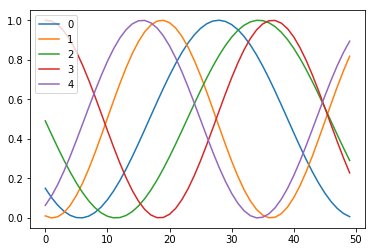

In [4]:
ax = pd.DataFrame(np.transpose(sample_data(5))).plot()
G_in = Input(shape=[10])
G, G_out = get_generative(G_in)
G.summary()

D_in = Input(shape=[50])
D, D_out = get_discriminative(D_in)
D.summary()

In [7]:
GAN_in = Input([10])
GAN, GAN_out = make_gan(GAN_in, G, D)
GAN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 10)                0         
_________________________________________________________________
model_1 (Model)              (None, 50)                12250     
_________________________________________________________________
model_2 (Model)              (None, 2)                 115452    
Total params: 127,702
Trainable params: 12,250
Non-trainable params: 115,452
_________________________________________________________________


In [105]:
pretrain(G, D)

Epoch 1/1
20000/20000 [==============================] - ETA: 3:20 - loss: 0.745 - ETA: 25s - loss: 0.373 - ETA: 14s - loss: 0.21 - ETA: 10s - loss: 0.13 - ETA: 8s - loss: 0.1056 - ETA: 7s - loss: 0.087 - ETA: 6s - loss: 0.071 - ETA: 6s - loss: 0.061 - ETA: 5s - loss: 0.053 - ETA: 5s - loss: 0.046 - ETA: 4s - loss: 0.041 - ETA: 4s - loss: 0.037 - ETA: 4s - loss: 0.034 - ETA: 4s - loss: 0.031 - ETA: 3s - loss: 0.029 - ETA: 3s - loss: 0.027 - ETA: 3s - loss: 0.026 - ETA: 3s - loss: 0.024 - ETA: 3s - loss: 0.023 - ETA: 3s - loss: 0.021 - ETA: 3s - loss: 0.020 - ETA: 3s - loss: 0.019 - ETA: 2s - loss: 0.018 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.017 - ETA: 2s - loss: 0.016 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.015 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.014 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.013 - ETA: 2s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.012 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.011 - ETA: 1s - loss: 0.010 - ETA

In [106]:
d_loss, g_loss = train(GAN, G, D, verbose=True)

HBox(children=(IntProgress(value=0, max=500), HTML(value='')))

Epoch #50: Generative Loss: 3.2680366039276123, Discriminative Loss: 0.7191373109817505
Epoch #100: Generative Loss: 1.880533218383789, Discriminative Loss: 0.30966484546661377
Epoch #150: Generative Loss: 4.161871910095215, Discriminative Loss: 0.051434654742479324
Epoch #200: Generative Loss: 3.7338500022888184, Discriminative Loss: 0.09952372312545776
Epoch #250: Generative Loss: 3.9842569828033447, Discriminative Loss: 0.04793567955493927
Epoch #300: Generative Loss: 4.294563293457031, Discriminative Loss: 0.06304902583360672
Epoch #350: Generative Loss: 2.835638999938965, Discriminative Loss: 0.09784887731075287
Epoch #400: Generative Loss: 3.9227592945098877, Discriminative Loss: 0.029597070068120956
Epoch #450: Generative Loss: 3.9247546195983887, Discriminative Loss: 0.02840055525302887
Epoch #500: Generative Loss: 3.687798500061035, Discriminative Loss: 0.040528856217861176



Text(0,0.5,'Loss')

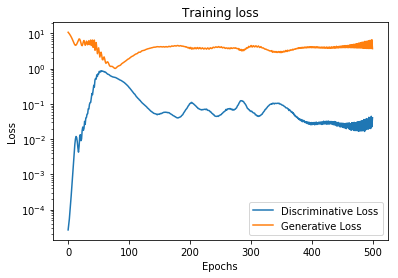

In [107]:
ax = pd.DataFrame(
    {
        'Generative Loss': g_loss,
        'Discriminative Loss': d_loss,
    }
).plot(title='Training loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

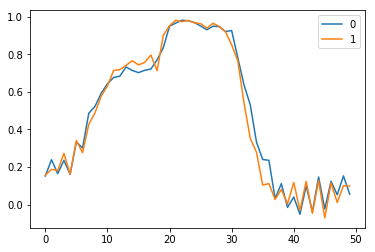

In [108]:
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).plot()

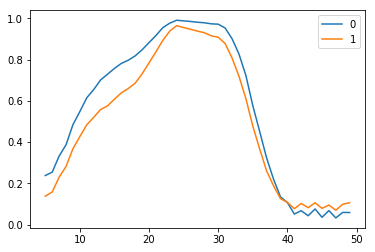

In [109]:
N_VIEWED_SAMPLES = 2
data_and_gen, _ = sample_data_and_gen(G, n_samples=N_VIEWED_SAMPLES)
pd.DataFrame(np.transpose(data_and_gen[N_VIEWED_SAMPLES:])).rolling(5).mean()[5:].plot()